# Temporal Targets by Tracking Membrane Potential

This notebook replicates the temporal coding experiments in the paper *`The fine line between dead neurons and sparsity in binarized spiking neural networks'* by Jason K. Eshraghian and Wei D. Lu (see section 4.1).

In [1]:
!pip install snntorch --quiet

     |████████████████████████████████| 62 kB 978 kB/s 


## Imports

In [223]:
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen
import snntorch.functional as SF
from snntorch import spikeplot as splt
from snntorch import utils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import seaborn as sns 

from IPython import display
import numpy as np
from tqdm import tqdm
import math
import random
from scipy.ndimage.filters import uniform_filter1d
import os

## Plotting Utility Functions

In [278]:
#@title
sns.set_theme()

def prep_for_plot(mem):
  return mem.cpu().detach().squeeze(-1).squeeze(-1)

def plot_quadrant(mem, spk_out, target_mem, spk_target, y1, y2, threshold=1, save=False, epoch1 = 1, epoch2=25, epoch3=100, fill=True):
  # Generate Plots
  gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.07])
  fig = plt.figure(figsize=(12,4.5),)
  ax1 = plt.subplot(gs[0,0])
  ax2 = plt.subplot(gs[1,0])
  ax3 = plt.subplot(gs[0,1])
  ax4 = plt.subplot(gs[1,1])
  ax5 = plt.subplot(gs[0,2])
  ax6 = plt.subplot(gs[1,2])
  ax7 = plt.subplot(gs[0,3])
  ax8 = plt.subplot(gs[1,3])

  mem = prep_for_plot(mem)
  spk_out = prep_for_plot(spk_out)
  target_mem = prep_for_plot(target_mem)
  epoch1_str = str(epoch1)
  epoch2_str = str(epoch2)
  epoch3_str = str(epoch3)

  fontsize = 25

  ########### TARGET ########
    # Plot membrane potential
  ax1.plot(target_mem)
  ax1.set_ylim([y1, y2]) # 0.1, 1.3
  ax1.set_ylabel("$u$", fontsize=fontsize, fontweight='bold')
  ax1.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax1.set_yticks([])
  ax1.set_xticks([])
  ax1.set_title("Target",fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_target, ax2, s=250, c="black", marker=".")
  ax2.set_ylabel("$z$", fontsize=fontsize, fontweight='bold')
  ax2.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax2.set_yticks([]) 
  ax2.set_xticks([])
  ax2.set_xlim(0, 100)

  ############## EPOCH 1 ########

  # Plot membrane potential
  ax3.plot(mem[epoch1])
  ax3.set_ylim([y1, y2]) # 0.1, 1.3
  ax3.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax3.set_yticks([])
  ax3.set_xticks([])
  ax3.set_title("$\gamma =$" + epoch1_str ,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch1], ax4, s=250, c="black", marker=".")
  # ax4.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax4.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax4.set_yticks([]) 
  ax4.set_xticks([])
  ax4.set_xlim(0, 100)

  ############## EPOCH 100 ########

  # Plot membrane potential
  ax5.plot(mem[epoch2])
  ax5.set_ylim([y1, y2]) # 0.1, 1.3
  # ax5.set_ylabel("$u^{~j}_t$", fontsize=fontsize, fontweight='bold')
  ax5.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax5.set_yticks([])
  ax5.set_xticks([]) 
  ax5.set_title("$\gamma =$" + epoch2_str,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch2], ax6, s=250, c="black", marker=".")
  # ax6.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax6.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax6.set_yticks([]) 
  ax6.set_xticks([])
  ax6.set_xlim(0, 100)

  ########## EPOCH 100 ##############
  # Plot membrane potential
  ax7.plot(mem[epoch3])
  ax7.set_ylim([y1, y2]) # 0.1, 1.3
  # ax7.set_ylabel("$u^{~j}_t$", fontsize=fontsize, fontweight='bold')
  ax7.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax7.set_yticks([])
  ax7.set_xticks([])
  ax7.set_title("$\gamma =$" + epoch3_str,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch3], ax8, s=250, c="black", marker=".")
  # ax8.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax8.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax8.set_yticks([]) 
  ax8.set_xticks([])
  ax8.set_xlim(0, 100)
  
  fig.tight_layout()
  plt.subplots_adjust(
                    # left=0.125,
                    # bottom=0.1, 
                    # right=0.9, 
                    # top=0.9, 
                    wspace=0.01, 
                    hspace=0.)
  
  if fill:
    ax1.fill_between(x, target_mem, step="pre", alpha=0.4, color='tab:blue')
    ax3.fill_between(x, mem[epoch1], step="pre", alpha=0.4, color='tab:blue')
    ax5.fill_between(x, mem[epoch2], step="pre", alpha=0.4, color='tab:blue')
    ax7.fill_between(x, mem[epoch3], step="pre", alpha=0.4, color='tab:blue')

  fig1 = plt.gcf()
  if save:
    fig1.savefig(save, dpi=600)

  plt.show()


def plot_quadrant_tha(mem, spk_out, target_mem, spk_target, y1, y2, 
                      threshold=[1, 1, 1], save=False, epoch1 = 1, epoch2=25, 
                      epoch3=100, fill=True):
  # Generate Plots
  gs = gridspec.GridSpec(2, 4, height_ratios=[1, 0.07])
  fig = plt.figure(figsize=(12,4.5),)
  ax1 = plt.subplot(gs[0,0])
  ax2 = plt.subplot(gs[1,0])
  ax3 = plt.subplot(gs[0,1])
  ax4 = plt.subplot(gs[1,1])
  ax5 = plt.subplot(gs[0,2])
  ax6 = plt.subplot(gs[1,2])
  ax7 = plt.subplot(gs[0,3])
  ax8 = plt.subplot(gs[1,3])

  mem = prep_for_plot(mem)
  spk_out = prep_for_plot(spk_out)
  target_mem = prep_for_plot(target_mem)
  epoch1_str = str(epoch1)
  epoch2_str = str(epoch2)
  epoch3_str = str(epoch3)

  fontsize = 25

  ########### TARGET ########
    # Plot membrane potential
  ax1.plot(target_mem)
  ax1.set_ylim([y1, y2]) # 0.1, 1.3
  ax1.set_ylabel("$u$", fontsize=fontsize, fontweight='bold')
  ax1.axhline(y=threshold[999], alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax1.set_yticks([])
  ax1.set_xticks([])
  ax1.set_title("Target",fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_target, ax2, s=250, c="black", marker=".")
  ax2.set_ylabel("$z$", fontsize=fontsize, fontweight='bold')
  ax2.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax2.set_yticks([]) 
  ax2.set_xticks([])
  ax2.set_xlim(0, 100)

  ############## EPOCH 1 ########

  # Plot membrane potential
  ax3.plot(mem[epoch1])
  ax3.set_ylim([y1, y2]) # 0.1, 1.3
  ax3.axhline(y=threshold[epoch1], alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax3.set_yticks([])
  ax3.set_xticks([])
  ax3.set_title("$\gamma =$" + epoch1_str ,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch1], ax4, s=250, c="black", marker=".")
  # ax4.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax4.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax4.set_yticks([]) 
  ax4.set_xticks([])
  ax4.set_xlim(0, 100)

  ############## EPOCH 100 ########

  # Plot membrane potential
  ax5.plot(mem[epoch2])
  ax5.set_ylim([y1, y2]) # 0.1, 1.3
  # ax5.set_ylabel("$u^{~j}_t$", fontsize=fontsize, fontweight='bold')
  ax5.axhline(y=threshold[epoch2], alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax5.set_yticks([])
  ax5.set_xticks([]) 
  ax5.set_title("$\gamma =$" + epoch2_str,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch2], ax6, s=250, c="black", marker=".")
  # ax6.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax6.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax6.set_yticks([]) 
  ax6.set_xticks([])
  ax6.set_xlim(0, 100)

  ########## EPOCH 100 ##############
  # Plot membrane potential
  ax7.plot(mem[epoch3])
  ax7.set_ylim([y1, y2]) # 0.1, 1.3
  # ax7.set_ylabel("$u^{~j}_t$", fontsize=fontsize, fontweight='bold')
  ax7.axhline(y=threshold[epoch3], alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax7.set_yticks([])
  ax7.set_xticks([])
  ax7.set_title("$\gamma =$" + epoch3_str,fontsize=fontsize, fontweight='bold')
  # plt.xlabel("Time") 

  # Plot output spike using spikeplot
  splt.raster(spk_out[epoch3], ax8, s=250, c="black", marker=".")
  # ax8.set_ylabel("$z^{~j}_t$", fontsize=fontsize, fontweight='bold') 
  ax8.set_xlabel("$t$", fontsize=fontsize, fontweight='bold')
  ax8.set_yticks([]) 
  ax8.set_xticks([])
  ax8.set_xlim(0, 100)
  
  fig.tight_layout()
  plt.subplots_adjust(
                    # left=0.125,
                    # bottom=0.1, 
                    # right=0.9, 
                    # top=0.9, 
                    wspace=0.01, 
                    hspace=0.)
  
  if fill:
    ax1.fill_between(x, target_mem, step="pre", alpha=0.4, color='tab:blue')
    ax3.fill_between(x, mem[epoch1], step="pre", alpha=0.4, color='tab:blue')
    ax5.fill_between(x, mem[epoch2], step="pre", alpha=0.4, color='tab:blue')
    ax7.fill_between(x, mem[epoch3], step="pre", alpha=0.4, color='tab:blue')

  fig1 = plt.gcf()
  if save:
    fig1.savefig(save, dpi=600)

  plt.show()


# 1. High Precision Testing
##  1.1 Choose some random hyperparameters

In [224]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
num_steps = 100
num_inputs = 100
num_hidden = 1000
batch_size = 1
beta=0.6
spike_time = 75

loss_fn = nn.MSELoss() 

In [225]:
def set_all_seeds(seed=0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds()

## 1.2 Generate Random Inputs and Membrane Trace Target
* The random inputs will be fed to the network
* The output neuron will be trained to replicate the evolution of the membrane trace generated below

In [226]:
input_prob = torch.rand(num_steps, batch_size, num_inputs).to(device)
input_data = spikegen.rate(input_prob, time_var_input=True)
target_mem = spikegen.targets_latency(torch.zeros(1, dtype=dtype, device=device), num_classes=1, first_spike_time=75, on_target=1.05, num_steps=100, interpolate=True)

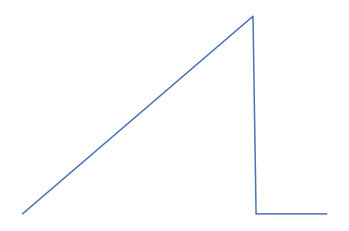

In [227]:
# membrane trace target: Threshold=1
splt.traces(target_mem, spk=False, dim=(1,1), spk_height=1)

## 1.3 Define network
100-1000-1 Dense Network

In [228]:
net = nn.Sequential(
    nn.Linear(num_inputs, num_hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True),
    nn.Linear(num_hidden, 1),
    snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True, output=True)
).to(device)

## 1.4 High-precision training loop
Start with high precision weights.

In [229]:
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999)) 
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 1000

mem_tot = []
spk_tot = []

for epoch in tqdm(range(num_epochs)):
  mem_rec = []
  spk_rec = []

  utils.reset(net)

  for step in range(num_steps):
    spk, mem = net(input_data[step])
    mem_rec.append(mem)
    spk_rec.append(spk)

  mem_rec = torch.stack(mem_rec)
  mem_tot.append(mem_rec)

  spk_rec = torch.stack(spk_rec)
  spk_tot.append(spk_rec)

  # loss = loss_fn(targets_spike, mem_rec) + 2*loss_fn(targets_spike[75], mem_rec[75])+ 5e-1*sum(spk_rec)  # full trace 
  loss = loss_fn(target_mem, mem_rec) # + 2 * loss_fn(targets_spike[75], mem_rec[75]) # + 0*(torch.exp(sum(spk_rec))-1)

  # clear previously stored gradients
  optimizer.zero_grad()

  # calculate the gradients
  loss.backward()

  # weight update
  optimizer.step()

mem_tot = torch.stack(mem_tot)
spk_tot = torch.stack(spk_tot)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.42it/s]


## 1.5 Plot Membrane Potential
$\gamma$ refers to the training iteration.

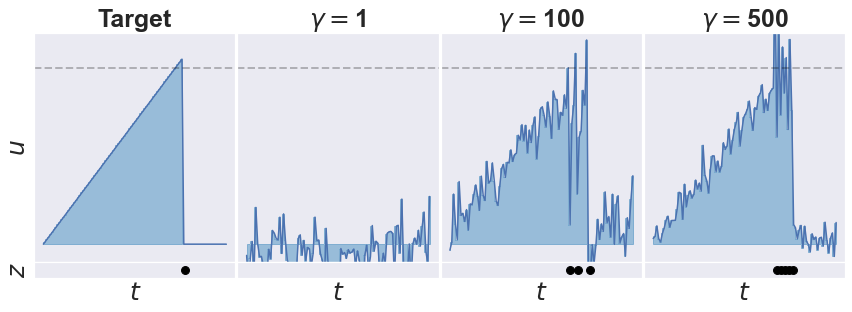

In [287]:
plot_quadrant(mem_tot, spk_tot, target_mem, spk_target, -0.1, 1.2, threshold=1, save="spk_time_flt.png", epoch1=1, epoch2=100, epoch3=500, fill=True) # save="spk_time_flt.png"

## 1.6 Evolution of membrane potential over training epochs

In [261]:
threshold = 1
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
x = np.arange(0, 100, 1) 

ax.set_xlim(0, num_steps)
ax.set_ylim(-0.5, 1.5)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(target_mem[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_tot[frame_num, x, 0,0].cpu().detach().numpy())
    time_text.set_text(f'Epoch: {frame_num}')

    # ax.plot([], [], ' ', label=str(frame_num))
    # ax.legend(loc='upper right')
    return (line, time_text)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30)
anim.save('spk_time_flt.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

# 2. Binarized Spike Timing: Threshold=1
The high precision simulation does a good job of tracking the desired membrane potential. There is instability when a spike occurs because of the discontinuous reset: when the neuron is reset, the weights try to offset the sudden change by increasing weights.

Now, let's test out binarized spiking neural nets. 
Before introducing threshold annealing, we will apply a threshold of $\theta=1$ to all neurons. The input of each axon can only ever be +1 or -1. 
We can expect the outcome to be extremely unstable.

## 2.1 Binarized Functions


In [262]:
class BinaryLinear(nn.Linear):
    def forward(self, input):
        binary_weight = binarize(self.weight)
        if self.bias is None:
            return F.linear(input, binary_weight)
        else:
            return F.linear(input, binary_weight, self.bias)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv


class BinarizeF(Function):

    @staticmethod
    def forward(ctx, input):
        output = input.new(input.size())
        output[input >= 0] = 1
        output[input < 0] = -1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

# aliases
binarize = BinarizeF.apply

## 2.2 Hyperparameters

In [263]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
num_steps = 100
num_inputs = 100
num_hidden = 1000
batch_size = 1
beta=0.15 

loss_fn = nn.MSELoss() 

## 2.3 Network Definition
Same architecture will be used all throughout: 100-1000-1 Dense Layers.

In [264]:
b_net = nn.Sequential(
    BinaryLinear(num_inputs, num_hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True),
    BinaryLinear(num_hidden, 1),
    snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True, output=True)
).to(device)

## 2.4 Binarized Training Loop

In [183]:
optimizer = torch.optim.SGD(b_net.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 1000
mem_tot_bin = []
spk_tot_bin = []

for epoch in tqdm(range(num_epochs)):
  mem_rec = []
  spk_rec = []

  utils.reset(net)

  for step in range(num_steps):
    spk, mem = b_net(input_data[step])
    mem_rec.append(mem)
    spk_rec.append(spk)

  spk_rec = torch.stack(spk_rec)
  mem_rec = torch.stack(mem_rec)
  mem_tot_bin.append(mem_rec)
  spk_tot_bin.append(spk_rec)

  loss = loss_fn(target_mem, mem_rec)

  # clear previously stored gradients
  optimizer.zero_grad()

  # calculate the gradients
  loss.backward()

  # weight update
  optimizer.step()

mem_tot_bin = torch.stack(mem_tot_bin)
spk_tot_bin = torch.stack(spk_tot_bin)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.58it/s]


## 2.5 Plot Membrane Potential

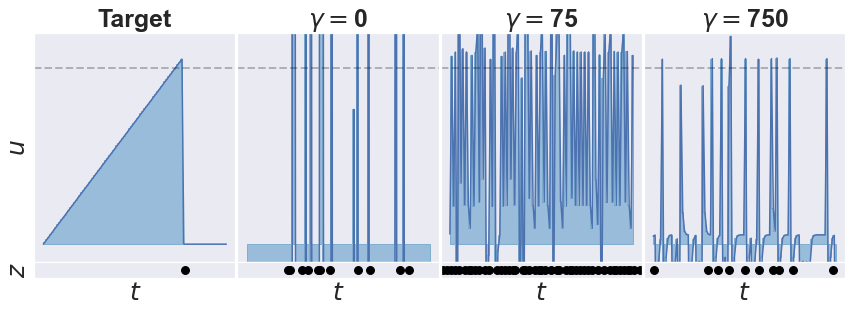

In [297]:
plot_quadrant(mem_tot_bin, spk_tot_bin, target_mem, spk_target, -0.1, 1.2, threshold=1, save='spk_time_bin.png', epoch1=0, epoch2=75, epoch3=750, fill=True) # save="spk_time_flt.png"

As expected, this doesn't look great. 
This somewhat resembles the pathological case described in section 2 of the paper, where BSNNs struggle to incorporate both memory dynamics and spike propagation. I.e., no smooth memory dynamics are visible above.

## 2.6 Evolution of membrane trace over training epochs

In [300]:
threshold = 1
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
x = np.arange(0, 100, 1) 

ax.set_xlim(0, num_steps)
ax.set_ylim(-0.5, 1.5)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(target_mem[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_tot_bin[frame_num, x, 0,0].cpu().detach().numpy())
    time_text.set_text(f'Epoch: {frame_num}')
    return (line, time_text)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30)
anim.save('spk_time_bin.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

## 2.7 Moving Average
Perhaps we will see better results if we take the moving average of the membrane potential (over epochs).

In [305]:
threshold = 1
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
x = np.arange(0, 100, 1)

N = 5 # size of filter
mem_avg_bin = uniform_filter1d(mem_tot_bin.cpu().detach(), size=N, axis=1)

ax.set_xlim(0, num_steps)
ax.set_ylim(-0.5, 1.5)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(target_mem[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_avg_bin[frame_num, x, 0,0])
    time_text.set_text(f'Epoch: {frame_num}')

    # ax.plot([], [], ' ', label=str(frame_num))
    # ax.legend(loc='upper right')
    return (line, time_text)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30)
anim.save('spk_time_bin_MVA.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

Perhaps not.

# 3. Wide threshold BNN
If we use a large threshold, then each spiking neuron would have a wider dynamic range state-space, and this could enable more precise tuning. 

The problem we will run into is, if the threshold is too high, then downstream spikes probably won't occur, and so learning will also fail to take place. Let's set the threhsold of all neurons to $\theta=50$. This is a significant jump from $\theta=1$. 

## 3.1 Hyperparameters

In [306]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
num_steps = 100
num_inputs = 100
num_hidden = 1000
batch_size = 1
beta=0.15
w_thr1 = 50
w_thr2 = 50  # 25 works well
on_target = w_thr2 + w_thr2*0.1
first_spike_time = 75

loss_fn = nn.MSELoss() 
# loss_fn = nn.CrossEntropyLoss()

## 3.2 Define target

In [307]:
targets_wthr = spikegen.targets_latency(torch.zeros(1, dtype=dtype, device=device), num_classes=1, first_spike_time=first_spike_time, on_target=on_target, num_steps=num_steps, interpolate=True)

## 3.3 Define network

In [308]:
wthr_net = nn.Sequential(
    BinaryLinear(num_inputs, num_hidden),
    snn.Leaky(beta=beta, threshold=w_thr1, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True),
    BinaryLinear(num_hidden, 1),
    snn.Leaky(beta=beta, threshold=w_thr2, spike_grad=surrogate.fast_sigmoid(slope=5), init_hidden=True, output=True)
).to(device)

## 3.4 Training Loop

In [310]:
optimizer = torch.optim.SGD(wthr_net.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 1000
mem_tot_wthr = []
spk_tot_wthr = []

for epoch in tqdm(range(num_epochs)):
  mem_rec = []
  spk_rec = []

  utils.reset(net)

  for step in range(num_steps):
    spk, mem = wthr_net(input_data[step])
    mem_rec.append(mem)
    spk_rec.append(spk)

  spk_rec = torch.stack(spk_rec)
  mem_rec = torch.stack(mem_rec)
  spk_tot_wthr.append(spk_rec)
  mem_tot_wthr.append(mem_rec)

  loss = loss_fn(targets_wthr, mem_rec)

  # clear previously stored gradients
  optimizer.zero_grad()

  # calculate the gradients
  loss.backward()

  # weight update
  optimizer.step()

mem_tot_wthr = torch.stack(mem_tot_wthr)
spk_tot_wthr = torch.stack(spk_tot_wthr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.41it/s]


## 3.5 Plot Membrane Potential

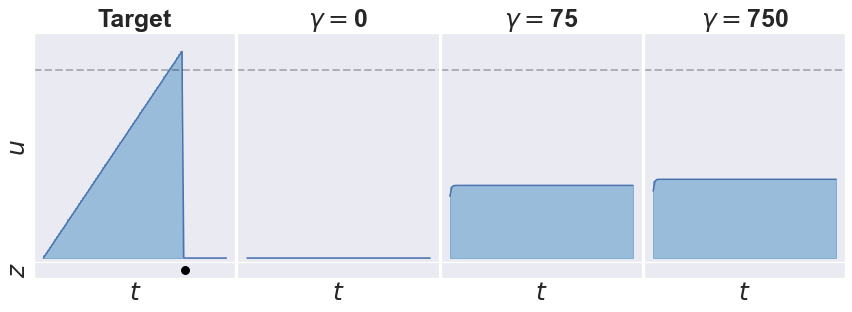

In [377]:
plot_quadrant(mem_tot_wthr, spk_tot_wthr, targets_wthr, spk_target, -1, 60, threshold=50, save="spk_time_wthr.png", epoch1=0, epoch2=75, epoch3=750, fill=True) # save="spk_time_flt.png"

## 3.6 Animation of membrane potential

This result doesn't fluctuate, but neither does it produce the desired behavior of spiking at the 75th time step - in fact, no spikes at all are produced. 

The membrane potential staying constant over time indicates the output neuron does not receive any spikes from the previous layer. Rather, it is the bias driving the second layer. The bias slowly increases until it hits roughly the mid-point of the threshold to minimize the overall loss over time.

If the bias was removed, the membrane potential would be stuck at zero. So clearly, this doesn't quite work either.

Note that the membrane potential falls just short of 25. This can be explained by the final steps of the target being set to 0, which suppresses the overall steady-state response.

In [316]:
threshold = 50
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
x = np.arange(0, 100, 1) 

ax.set_xlim(0, num_steps)
ax.set_ylim(-1, 60)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(targets_wthr[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_tot_wthr[frame_num, x, 0,0].cpu().detach().numpy())
    time_text.set_text(f'Epoch: {frame_num}')

    # ax.plot([], [], ' ', label=str(frame_num))
    # ax.legend(loc='upper right')
    return (line, time_text)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30)
anim.save('spk_time_wthr.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

# 4. Threshold annealing
## 4.1 Define Threshold Annealing Function

If we slowly anneal the threshold from a small value to a larger value, this will result in strong spiking activity in early epochs which avoids the dead neuron problem we saw in the previous case where $\theta=50$.

We implement the most naive form of threshold annealing below with exponential relaxation of threshold toward a steady state, completely independent of the input data. The same threshold is applied to all neurons in all layers.

In [317]:
def thr_annealing(conf, network):
    alpha_thr1 = conf['alpha_thr1']
    alpha_thr2 = conf['alpha_thr2']

    thr_final1 = conf['thr_final1']
    thr_final2 = conf['thr_final2']

    with torch.no_grad():
      network.lif1.threshold += (thr_final1 - network.lif1.threshold) * alpha_thr1
      network.lif2.threshold += (thr_final2 - network.lif2.threshold) * alpha_thr2

## 4.2 Define Hyperparameters
As before, we set the final threshold to 50. But let's start with 5.0, and gradually warm it up to 50. `alpha_thr1` and `alpha_thr2` are the inverse time constants of the threshold evolution.

In [318]:
config = {
    
    'thr_init1' : 5.0,
    'thr_init2' : 5.0,

    'alpha_thr1' : 5e-3,
    'alpha_thr2' : 5e-3,

    'thr_final1' : 50.0,
    'thr_final2' : 50.0,
}

In [319]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float
num_steps = 100
num_inputs = 100
num_hidden = 1000
batch_size = 1
beta=0.15
on_target = config['thr_final2'] + config['thr_final2']*0.1

loss_fn = nn.MSELoss() 
# loss_fn = nn.CrossEntropyLoss()

## 4.3 Define Target

In [320]:
targets_tha = spikegen.targets_latency(torch.zeros(1, dtype=dtype, device=device), num_classes=1, first_spike_time=75, on_target=on_target, num_steps=num_steps, interpolate=True)

## 4.4 Define network

In [321]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    beta = 0.15
    spike_grad = surrogate.fast_sigmoid(slope=5)

    self.fc1 = BinaryLinear(num_inputs, num_hidden)
    self.fc2 = BinaryLinear(num_hidden, 1)

    self.lif1 = snn.Leaky(beta=beta, threshold=config['thr_init1'], spike_grad = spike_grad)
    self.lif2 = snn.Leaky(beta=beta, threshold=config['thr_init2'], spike_grad=spike_grad)

  def forward(self, x):
    mem1 = self.lif1.init_leaky() 
    mem2 = self.lif2.init_leaky() 

    spk2_rec = []
    mem2_rec = []

    for step in range(x.size(0)):
      cur1 = self.fc1(x[step])
      spk1, mem1 = self.lif1(cur1, mem1)
      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      spk2_rec.append(spk2)
      mem2_rec.append(mem2)
    
    return torch.stack(spk2_rec), torch.stack(mem2_rec)

net_tha = Net().to(device)

## 4.5 Training Loop

In [322]:
optimizer = torch.optim.SGD(net_tha.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 1000
mem_tot_tha = []
spk_tot_tha = []
thr_L1 = []
thr_L2 = []

for epoch in tqdm(range(num_epochs)):

  spk_rec, mem_rec = net_tha(input_data)
  spk_tot_tha.append(spk_rec)
  mem_tot_tha.append(mem_rec)
  loss = loss_fn(targets_tha, mem_rec)

  # clear previously stored gradients
  optimizer.zero_grad()

  # calculate the gradients
  loss.backward()

  # weight update
  optimizer.step()

  thr_L1.append(net_tha.lif1.threshold.item())
  thr_L2.append(net_tha.lif2.threshold.item())

  thr_annealing(config, net_tha)
  

mem_tot_tha = torch.stack(mem_tot_tha)
spk_tot_tha = torch.stack(spk_tot_tha)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s]


## 4.6 Plot Membrane Potential

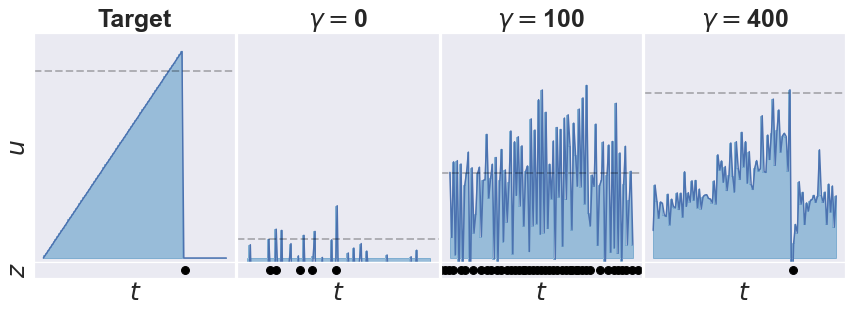

In [368]:
plot_quadrant_tha(mem_tot_tha, spk_tot_tha, targets_tha, spk_target, -1, 60, threshold=thr_L1, save="spk_time_tha.png", epoch1=0, epoch2=100, epoch3=400, fill=True) # save="spk_time_flt.png"

In [381]:
thr_L1[400]

43.940372467041016

This is looking quite nice as training progresses! Let's see the animated version to get better insight.

## 4.7 Animation of Membrane Potential

In [373]:
threshold = 50
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
thr_line, = ax.plot([])
thr_text1 = ax.text(0.98, 0.91,'',horizontalalignment='right',verticalalignment='top', transform=ax.transAxes, size='large')
x = np.arange(0, 100, 1) 

ax.set_xlim(0, num_steps)
ax.set_ylim(-1, 60)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(targets_tha[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_tot_tha[frame_num, x, 0,0].cpu().detach().numpy())
    thr_line.set_data(x, thr_L1[frame_num])
    thr_text1.set_text(f'Threshold: {thr_L1[frame_num]:.3f}')
    time_text.set_text(f'Epoch: {frame_num}')

    # ax.plot([], [], ' ', label=str(frame_num))
    # ax.legend(loc='upper right')
    return (line, time_text, thr_text1)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30) # num_epochs
anim.save('spk_time_tha.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

To begin with, the several spikes trigger a sudden explosion in activity as the neuron tries to climb its way to $u=50$. Sensory overload. 

But as the threshold warms up further, activity becomes sparser until finally, the neuron actually hits the desired firing time at several epochs.

## 4.8 Moving Average of Membrane

In [376]:
threshold = 50
fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
thr_line, = ax.plot([])
thr_text1 = ax.text(0.98, 0.91,'',horizontalalignment='right',verticalalignment='top', transform=ax.transAxes, size='large')
x = np.arange(0, 100, 1) 


N = 5 # size of filter
mem_avg_tha = uniform_filter1d(mem_tot_tha.cpu().detach(), size=N, axis=1)

ax.set_xlim(0, num_steps)
ax.set_ylim(-1, 60)
time_text = ax.text(0.02, 0.98,'',horizontalalignment='left',
                    verticalalignment='top', transform=ax.transAxes, size='large')

ax.set_ylabel('Membrane Potential ($u$)')
ax.set_xlabel('Time Steps')
ax.plot(targets_tha[:, 0, 0].cpu().detach().numpy(), label='Target', linestyle='dashed')
ax.axhline(y=threshold, alpha=0.25, linestyle="dashed", c="black", linewidth=2)


def animate(frame_num):
    line.set_data(x, mem_avg_tha[frame_num, x, 0,0])
    thr_line.set_data(x, thr_L1[frame_num])
    thr_text1.set_text(f'Threshold: {thr_L1[frame_num]:.3f}')
    time_text.set_text(f'Epoch: {frame_num}')

    # ax.plot([], [], ' ', label=str(frame_num))
    # ax.legend(loc='upper right')
    return (line, time_text, thr_text1)

anim = FuncAnimation(fig, animate, frames=num_epochs, interval=30) # num_epochs
anim.save('spk_time_tha_MVA.mp4', fps=25, extra_args=['-vcodec', 'libx264'], dpi=300)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

Not only do we see learning taking place, but the values chosen are completely arbitary. When writing this notebook, this was the first result we obtained. It is likely something more precise could be obtained by choosing layer-independent thresholds & annealing rates.